In [1]:
# 다르게 표현하면 모든 클래스에 대해서 원-핫 인코딩을 통해 얻은 원-핫 벡터들은 모든 쌍에 대해서 유클리드 거리를 구해도 
# 전부 유클리드 거리가 동일합니다. 원-핫 벡터는 이처럼 각 클래스의 표현 방법이 무작위성을 가진다는 점을 표현할 수 있습니다. 
# 뒤에서 다시 언급되겠지만 이러한 원-핫 벡터의 관계의 무작위성은 때로는 단어의 유사성을 구할 수 없다는 단점으로 언급되기도 합니다.
# 결국 소프트맥스 회귀는 선택지의 개수만큼의 차원을 가지는 벡터를 만들고, 해당 벡터가 벡터의 모든 원소의 합이 1이 되도록 원소들의 값을 변환시키는 어떤 함수를 지나게 만들어야 합니다.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]# 텐서의 shape은 (8,4) 이다
y_train = [2, 2, 2, 1, 1, 1, 0, 0]#텐서의 shape은 (,8) 이다
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
# x_train의 크기는 8 × 4이며, y_train의 크기는 8 × 1입니다. 그런데 최종 사용할 레이블은 y_train에서 원-핫 인코딩을 한 결과이어야 합니다. 
# 클래스의 개수는 3개이므로 y_train에 원-핫 인코딩한 결과는 8 × 3의 개수를 가져야 합니다.
# 여기서 1은 두 번째 차원 (index 1)을 기준으로 값을 할당한다는 의미입니다. 
# y_train.unsqueeze(1)는 새롭게 생성된 두 번째 차원에서 1을 할당할 위치를 나타냅니다.
# 마지막으로, 1은 할당하고자 하는 값인 1을 나타냅니다.
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


torch.Size([8, 3])
Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.622999
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


In [2]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)
    def forward(self,x):
        return self.linear(x)
model = SoftmaxClassifierModel()
#혹은 
model = nn.Linear(4,3)
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 3.554311
Epoch  100/1000 Cost: 0.640043
Epoch  200/1000 Cost: 0.556386
Epoch  300/1000 Cost: 0.501992
Epoch  400/1000 Cost: 0.457725
Epoch  500/1000 Cost: 0.418299
Epoch  600/1000 Cost: 0.381315
Epoch  700/1000 Cost: 0.345244
Epoch  800/1000 Cost: 0.308956
Epoch  900/1000 Cost: 0.272294
Epoch 1000/1000 Cost: 0.243713


In [1]:
#mnist 데이터 분류하기
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# hyperparameters
training_epochs = 15
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
# dataset loader
data_loader = DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)
#drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다.
#1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때
#128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다.
#이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')


다음 기기로 학습합니다: cpu


100%|██████████| 9912422/9912422 [00:02<00:00, 4107426.43it/s] 


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28979831.06it/s]


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3003610.55it/s]


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4553185.65it/s]


Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577745
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404700
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526860
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422705
Learning finished


Accuracy: 0.8883000016212463
Label:  2
Prediction:  8


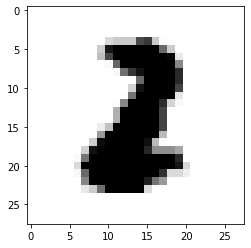

In [17]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
